Downloads :

In [ ]:
!pip install kagglehub

Import :

In [ ]:
import kagglehub
import os
import shutil
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import random
from IPython.display import Image,display
import glob
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, Input,Model
from PIL import Image
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.layers import Input, Conv2D, Add, ReLU, UpSampling2D
from keras.optimizers import Adam


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dimensi0n/imagenet-256")

print("Path to dataset files:", path)

100%|██████████| 7.15G/7.15G [00:57<00:00, 133MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/dimensi0n/imagenet-256/versions/1


In [ ]:
shutil.move(path,"./")

In [ ]:
shutil.rmtree("./dataset")

In [ ]:

def move_and_rename_images(source_folder, destination_folder):
    """
    Moves all images from a source folder (including subfolders) to a destination folder,
    renaming them sequentially as image1, image2, etc.

    Args:
        source_folder: The path to the source folder.
        destination_folder: The path to the destination folder.
    """

    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    image_extensions = ('.jpg', '.jpeg', '.png', '.gif', '.bmp')  # Add more if needed
    image_files = []
    for root, _, files in os.walk(source_folder):
        for file in files:
            if file.lower().endswith(image_extensions):
                image_files.append(os.path.join(root, file))

    for i, image_file in enumerate(image_files):
        new_filename = f"image{i+1}{os.path.splitext(image_file)[1]}"
        destination_path = os.path.join(destination_folder, new_filename)
        try:
          shutil.move(image_file, destination_path)
          print(f"Moved and renamed '{image_file}' to '{destination_path}'")
        except shutil.Error as e:
          print(f"Error moving '{image_file}': {e}")
        except FileNotFoundError as e:
          print(f"Error moving '{image_file}': {e}")


move_and_rename_images(path, "./dataset")

In [ ]:
def move_random_images(input_dir, output_dir, num_images):
    """
    Déplace aléatoirement des images depuis des sous-dossiers d'un dossier d'entrée vers un dossier de sortie,
    en les renommant selon un format séquentiel (image1, image2, etc.).

    :param input_dir: Chemin du dossier d'entrée contenant des sous-dossiers avec des images.
    :param output_dir: Chemin du dossier de sortie où les images seront déplacées.
    :param num_images: Nombre d'images à déplacer.
    """
    # Vérifie si le dossier d'entrée existe
    if not os.path.isdir(input_dir):
        raise ValueError(f"Le dossier d'entrée {input_dir} n'existe pas.")

    # Crée le dossier de sortie s'il n'existe pas
    os.makedirs(output_dir, exist_ok=True)

    # Récupère toutes les images dans les sous-dossiers
    all_images = []
    for root, _, files in os.walk(input_dir):
        for file in files:
            if file.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".gif")):
                all_images.append(os.path.join(root, file))

    # Vérifie si le nombre demandé d'images est disponible
    if len(all_images) < num_images:
        raise ValueError(f"Seulement {len(all_images)} images disponibles, mais {num_images} demandées.")

    # Sélectionne aléatoirement les images
    selected_images = random.sample(all_images, num_images)

    # Déplace et renomme les images sélectionnées
    for idx, image_path in enumerate(selected_images, start=1):
        new_name = f"image{idx}.jpg"  # Renomme toutes les images en .jpg
        destination_path = os.path.join(output_dir, new_name)
        shutil.move(image_path, destination_path)

    print(f"{num_images} images ont été déplacées et renommées dans {output_dir}.")

move_random_images(path,"./dataset",180000)

180000 images ont été déplacées et renommées dans ./dataset.


In [ ]:

dataset_path = "/content/dataset"
image_count = 0

for filename in os.listdir(dataset_path):
    if os.path.isfile(os.path.join(dataset_path, filename)):
        image_count += 1

print(f"Nombre d'images dans le dossier dataset/dataset : {image_count}")

Nombre d'images dans le dossier dataset/dataset : 180000


In [ ]:

def resize_images(source_folder, destination_folder):
    """
    Resizes all images in a source folder by half and saves them to a destination folder.

    Args:
        source_folder: Path to the source folder containing images.
        destination_folder: Path to the destination folder for resized images.
    """

    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    for filename in os.listdir(source_folder):
        source_path = os.path.join(source_folder, filename)
        if os.path.isfile(source_path):
            try:
                img = cv2.imread(source_path)
                if img is not None:
                    height, width = img.shape[:2]
                    resized_img = cv2.resize(img, (width // 2, height // 2))
                    destination_path = os.path.join(destination_folder, filename)
                    cv2.imwrite(destination_path, resized_img)
                    print(f"Resized and saved: {filename}")
                else:
                    print(f"Could not read image: {filename}")
            except Exception as e:
                print(f"Error processing {filename}: {e}")


resize_images("./dataset", "./resized_dataset")

In [ ]:

def downscaleImage_blur(input_path, output_path, scale=4, kernel_size=5):

    # Vérifier si le dossier de sortie existe, sinon le créer
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    # Liste tous les fichiers dans le dossier d'entrée
    for filename in os.listdir(input_path):
        # Crée le chemin complet du fichier
        input_image_path = os.path.join(input_path, filename)

        # Vérifie que c'est un fichier image (extensions .jpg, .jpeg, .png, etc.)
        if os.path.isfile(input_image_path) and filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
            # Charger l'image haute résolution (HR)
            img_hr = cv2.imread(input_image_path)

            # Vérifier que l'image a été correctement chargée
            if img_hr is None:
                print(f"Erreur lors du chargement de l'image : {input_image_path}")
                continue

            # Appliquer un flou gaussien à l'image
            img_blurred = cv2.GaussianBlur(img_hr, (kernel_size, kernel_size), 0)

            # Récupérer la taille originale de l'image
            height, width = img_hr.shape[:2]

            # Sous-échantillonner l'image par un facteur de downscaling
            lr_img = cv2.resize(img_blurred, (width // scale, height // scale), interpolation=cv2.INTER_CUBIC)

            # Rééchantillonner à la taille d'origine en utilisant l'interpolation bicubique
            lr_img = cv2.resize(lr_img, (width, height), interpolation=cv2.INTER_CUBIC)

            # Créer le chemin pour sauvegarder l'image downscalée dans le dossier de sortie
            output_image_path = os.path.join(output_path, filename)

            # Sauvegarder l'image basse résolution (LR) dans le dossier de sortie
            cv2.imwrite(output_image_path, lr_img)


In [ ]:
#downscale without blur
def downscaleImage(input_path, output_path, scale=4):

    # Vérifier si le dossier de sortie existe, sinon le créer
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    # Liste tous les fichiers dans le dossier d'entrée
    for filename in os.listdir(input_path):
        # Crée le chemin complet du fichier
        input_image_path = os.path.join(input_path, filename)

        # Vérifie que c'est un fichier image (extensions .jpg, .jpeg, .png, etc.)
        if os.path.isfile(input_image_path) and filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
            # Charger l'image haute résolution (HR)
            img_hr = cv2.imread(input_image_path)

            # Vérifier que l'image a été correctement chargée
            if img_hr is None:
                print(f"Erreur lors du chargement de l'image : {input_image_path}")
                continue

            # Récupérer la taille originale de l'image
            height, width = img_hr.shape[:2]

            # Sous-échantillonner l'image par un facteur de downscaling
            lr_img = cv2.resize(img_hr, (width // scale, height // scale), interpolation=cv2.INTER_AREA)

            # Rééchantillonner à la taille d'origine en utilisant l'interpolation bicubique
            lr_img = cv2.resize(lr_img, (width, height), interpolation=cv2.INTER_CUBIC)

            # Créer le chemin pour sauvegarder l'image downscalée dans le dossier de sortie
            output_image_path = os.path.join(output_path, filename)

            # Sauvegarder l'image basse résolution (LR) dans le dossier de sortie
            cv2.imwrite(output_image_path, lr_img)

In [ ]:
shutil.rmtree("./dataset_lr")


In [ ]:
input_directory = "/content/dataset"
output_directory = "/content/dataset_lr"
downscaleImage(input_directory, output_directory, scale=3)


In [ ]:

input_directory = "/content/dataset"
output_directory = "/content/dataset_lr"
downscaleImage_blur(input_directory, output_directory, scale=3,kernel_size=5)

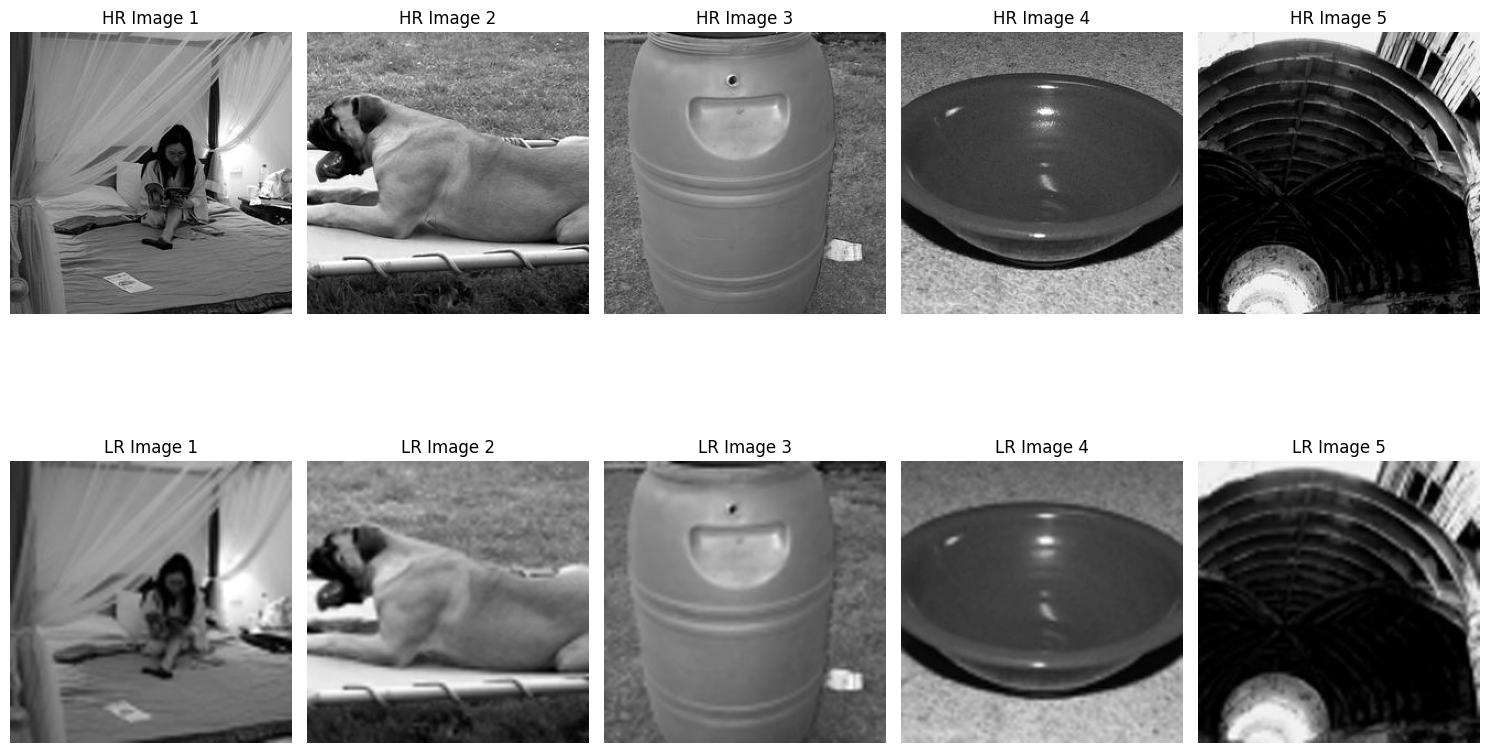

In [ ]:
# prompt: display in grayscale an image from folder hr and lr

import matplotlib.pyplot as plt
import cv2
import os

# Function to display images in grayscale
def display_grayscale_images(hr_folder, lr_folder):
    hr_images = [f for f in os.listdir(hr_folder) if os.path.isfile(os.path.join(hr_folder, f))]
    lr_images = [f for f in os.listdir(lr_folder) if os.path.isfile(os.path.join(lr_folder, f))]

    num_images_to_display = min(len(hr_images), len(lr_images), 5) # Limit to 5 for display

    plt.figure(figsize=(15, 10))
    for i in range(num_images_to_display):
      hr_img_path = os.path.join(hr_folder, hr_images[i])
      lr_img_path = os.path.join(lr_folder, lr_images[i])

      hr_img = cv2.imread(hr_img_path, cv2.IMREAD_GRAYSCALE)
      lr_img = cv2.imread(lr_img_path, cv2.IMREAD_GRAYSCALE)

      plt.subplot(2, num_images_to_display, i + 1)
      plt.imshow(hr_img, cmap='gray')
      plt.title(f"HR Image {i+1}")
      plt.axis('off')

      plt.subplot(2, num_images_to_display, i + num_images_to_display + 1)
      plt.imshow(lr_img, cmap='gray')
      plt.title(f"LR Image {i+1}")
      plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
hr_image_folder = "/content/dataset"
lr_image_folder = "/content/dataset_lr"

display_grayscale_images(hr_image_folder, lr_image_folder)

In [ ]:
from PIL import Image
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor, Resize

In [ ]:
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        # Couche 1 : extraction de caractéristiques
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=128, kernel_size=9, padding=4)
        self.relu1 = nn.ReLU()

        # Couche 2 : non-linéarité et mapping
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=1)
        self.relu2 = nn.ReLU()

        # Couche 3 : reconstruction
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=5, padding=2)

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.conv3(x)
        return x


In [ ]:
import os
import random
import shutil

# Répertoires
lr_dir = "./dataset_lr"
hr_dir = "./dataset"
train_lr_dir = "./train_lr"
val_lr_dir = "./val_lr"
test_lr_dir = "./test_lr"
train_hr_dir =  "./train_hr"
val_hr_dir = "./val_hr"
test_hr_dir = "./test_hr"

# Créer les dossiers pour train, val, test
for folder in [train_lr_dir, val_lr_dir, test_lr_dir, train_hr_dir, val_hr_dir, test_hr_dir]:
    os.makedirs(folder, exist_ok=True)

# Récupérer la liste des fichiers
lr_images = sorted(os.listdir(lr_dir))  # Tri pour être sûr que les paires sont alignées
hr_images = sorted(os.listdir(hr_dir))

# Nombre d'images total
total_images = len(lr_images)

# Fraction pour validation et test (80% train, 10% validation, 10% test)
train_size = int(0.8 * total_images)
val_size = int(0.1 * total_images)
test_size = total_images - train_size - val_size

# Mélanger les indices
indices = list(range(total_images))
random.shuffle(indices)

# Séparer les indices pour train, val, test
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size+val_size]
test_indices = indices[train_size+val_size:]

# Déplacer les images dans les bons dossiers
for i in train_indices:
    shutil.copy(os.path.join(lr_dir, lr_images[i]), train_lr_dir)
    shutil.copy(os.path.join(hr_dir, hr_images[i]), train_hr_dir)

for i in val_indices:
    shutil.copy(os.path.join(lr_dir, lr_images[i]), val_lr_dir)
    shutil.copy(os.path.join(hr_dir, hr_images[i]), val_hr_dir)

for i in test_indices:
    shutil.copy(os.path.join(lr_dir, lr_images[i]), test_lr_dir)
    shutil.copy(os.path.join(hr_dir, hr_images[i]), test_hr_dir)

print(f"Dataset séparé en {train_size} images d'entraînement, {val_size} de validation, {test_size} de test.")


Dataset séparé en 144000 images d'entraînement, 18000 de validation, 18000 de test.


In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from PIL import Image

# Dataset personnalisé
class SRDataset(Dataset):
    def __init__(self, lr_dir, hr_dir, transform=None):
        self.lr_dir = lr_dir
        self.hr_dir = hr_dir
        self.lr_images = sorted(os.listdir(lr_dir))
        self.hr_images = sorted(os.listdir(hr_dir))
        self.transform = transform

    def __len__(self):
        return len(self.lr_images)

    def __getitem__(self, idx):
        # Chargement des images LR et HR
        lr_path = os.path.join(self.lr_dir, self.lr_images[idx])
        hr_path = os.path.join(self.hr_dir, self.hr_images[idx])

        lr_image = Image.open(lr_path).convert("L")  # Noir et blanc
        hr_image = Image.open(hr_path).convert("L")  # Noir et blanc

        if self.transform:
            lr_image = self.transform(lr_image)
            hr_image = self.transform(hr_image)

        return lr_image, hr_image


# Transformations pour convertir les images en tenseurs
transform = ToTensor()

# Répertoires des ensembles
train_lr_dir = "./train_lr"
train_hr_dir = "./train_hr"
val_lr_dir = "./val_lr"
val_hr_dir = "./val_hr"
test_lr_dir = "./test_lr"
test_hr_dir = "./test_hr"

# Chargement des ensembles avec DataLoader
train_dataset = SRDataset(train_lr_dir, train_hr_dir, transform=transform)
val_dataset = SRDataset(val_lr_dir, val_hr_dir, transform=transform)
test_dataset = SRDataset(test_lr_dir, test_hr_dir, transform=transform)

# DataLoader pour les batches
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


In [ ]:
from tqdm import tqdm  # Progress bar pour PyTorch

# Boucle d'entraînement

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# Initialisation du modèle, de la perte et de l'optimiseur
model = SRCNN().to(device)
criterion = nn.MSELoss()  # Perte MSE pour la super-résolution
optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 10
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    model.train()
    train_loss = 0.0

    # Boucle sur les batches avec suivi (via tqdm)
    for lr_images, hr_images in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        lr_images = lr_images.to(device)
        hr_images = hr_images.to(device)

        # Prédictions et calcul de la perte
        outputs = model(lr_images)
        loss = criterion(outputs, hr_images)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation après chaque époque
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for lr_images, hr_images in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}"):
            lr_images = lr_images.to(device)
            hr_images = hr_images.to(device)

            outputs = model(lr_images)
            loss = criterion(outputs, hr_images)
            val_loss += loss.item()

    # Affichage des résultats pour l'époque en cours
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(val_loader):.4f}")


Using device: cuda

Epoch 1/10


Validation Epoch 1: 100%|██████████| 141/141 [00:46<00:00,  3.04it/s]


Epoch 1/10 | Train Loss: 0.0086 | Val Loss: 0.0038

Epoch 2/10


Validation Epoch 2: 100%|██████████| 141/141 [00:46<00:00,  3.05it/s]


Epoch 2/10 | Train Loss: 0.0037 | Val Loss: 0.0036

Epoch 3/10


Validation Epoch 3: 100%|██████████| 141/141 [00:45<00:00,  3.11it/s]


Epoch 3/10 | Train Loss: 0.0037 | Val Loss: 0.0036

Epoch 4/10


Validation Epoch 4: 100%|██████████| 141/141 [00:46<00:00,  3.05it/s]


Epoch 4/10 | Train Loss: 0.0036 | Val Loss: 0.0036

Epoch 5/10


Validation Epoch 5: 100%|██████████| 141/141 [00:46<00:00,  3.03it/s]


Epoch 5/10 | Train Loss: 0.0036 | Val Loss: 0.0035

Epoch 6/10


Validation Epoch 6: 100%|██████████| 141/141 [00:46<00:00,  3.01it/s]


Epoch 6/10 | Train Loss: 0.0036 | Val Loss: 0.0035

Epoch 7/10


Validation Epoch 7: 100%|██████████| 141/141 [00:46<00:00,  3.04it/s]


Epoch 7/10 | Train Loss: 0.0035 | Val Loss: 0.0035

Epoch 8/10


Validation Epoch 8: 100%|██████████| 141/141 [00:46<00:00,  3.02it/s]


Epoch 8/10 | Train Loss: 0.0035 | Val Loss: 0.0035

Epoch 9/10


Validation Epoch 9: 100%|██████████| 141/141 [00:46<00:00,  3.03it/s]


Epoch 9/10 | Train Loss: 0.0035 | Val Loss: 0.0035

Epoch 10/10


Validation Epoch 10: 100%|██████████| 141/141 [00:46<00:00,  3.05it/s]

Epoch 10/10 | Train Loss: 0.0035 | Val Loss: 0.0035


In [ ]:

torch.save(model.state_dict(), 'srcnn_model.pth')

# Fonction pour tester le modèle
def test_model(model, test_loader, device):
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for lr_images, hr_images in tqdm(test_loader, desc="Testing"):
            lr_images = lr_images.to(device)
            hr_images = hr_images.to(device)

            outputs = model(lr_images)
            loss = criterion(outputs, hr_images)
            test_loss += loss.item()

    print(f"Test Loss: {test_loss/len(test_loader):.4f}")


# Charger le modèle enregistré et tester
model = SRCNN().to(device)  # Créer une nouvelle instance du modèle
model.load_state_dict(torch.load('srcnn_model.pth'))
test_model(model, test_loader, device)

<ipython-input-36-67777c2c6e2e>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('srcnn_model.pth'))
Testing: 100%|██████████| 141/141 [00:

Test Loss: 0.0035


In [ ]:

import math

def psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

# Example usage (assuming you have hr_images and outputs from the model)
def calculate_psnr(model, test_loader, device):
  model.eval()
  avg_psnr = 0
  with torch.no_grad():
    for lr_images, hr_images in tqdm(test_loader, desc="Calculating PSNR"):
        lr_images = lr_images.to(device)
        hr_images = hr_images.to(device)

        outputs = model(lr_images)

        # Convert to numpy arrays for PSNR calculation
        for i in range(len(hr_images)):
          hr_img_np = (hr_images[i].cpu().numpy() * 255).astype(np.uint8)
          output_img_np = (outputs[i].cpu().numpy() * 255).astype(np.uint8)
          avg_psnr += psnr(hr_img_np, output_img_np)


  print(f"Average PSNR: {avg_psnr / len(test_loader.dataset):.4f}")

# Load the model and calculate PSNR
model = SRCNN().to(device)  # Create a new instance of the model
model.load_state_dict(torch.load('srcnn_model.pth'))
calculate_psnr(model, test_loader, device)

<ipython-input-37-ade4afca6bf0>:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('srcnn_model.pth'))
Calculating PSNR: 100%|██████████| 141

Average PSNR: 32.5261


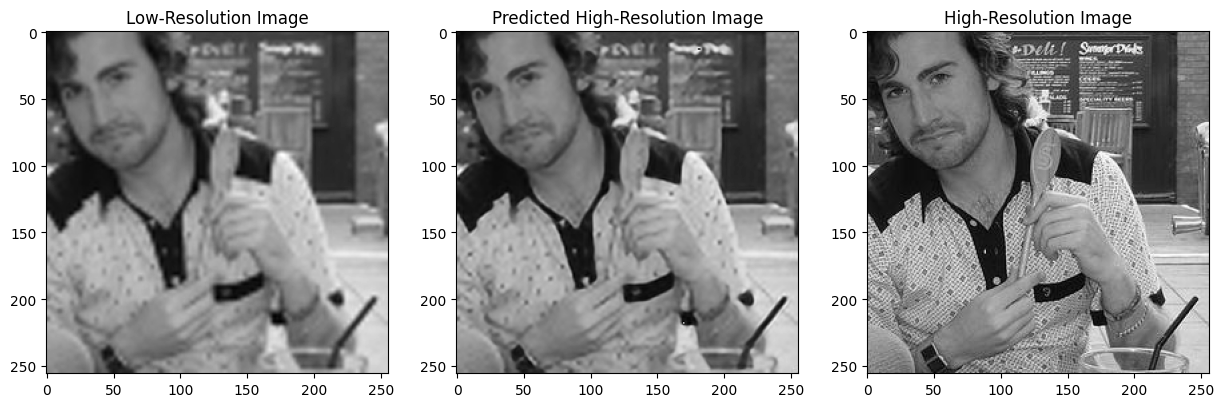

In [ ]:

import random
import matplotlib.pyplot as plt
import torch
from torchvision.transforms import ToPILImage

# Assuming test_loader, model, and device are defined as in your previous code

# Choose a random image from the test set
random_index = random.randint(0, len(test_dataset) - 1)
lr_image, hr_image = test_dataset[random_index]

# Perform prediction
model.eval()
with torch.no_grad():
    lr_image = lr_image.unsqueeze(0).to(device)  # Add batch dimension
    output = model(lr_image)

# Convert tensors to PIL Images for display
to_pil = ToPILImage()
lr_image_pil = to_pil(lr_image.squeeze(0).cpu())
hr_image_pil = to_pil(hr_image.cpu())
output_pil = to_pil(output.squeeze(0).cpu())

# Display the images
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(lr_image_pil, cmap='gray')
plt.title('Low-Resolution Image')

plt.subplot(1, 3, 2)
plt.imshow(output_pil, cmap='gray')
plt.title('Predicted High-Resolution Image')

plt.subplot(1, 3, 3)
plt.imshow(hr_image_pil, cmap='gray')
plt.title('High-Resolution Image')

plt.show()